# Explainable Large Langague Model's

**Author:** Lennox Anderson

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1e8LLQ_dV702G1NieIQ1a1tuWPLdjiVpB?usp=sharing)

**Null Hypothesis (H₀):**
The fine-tuned LegalBERT model's predictions on legislative data are robust to minor perturbations in prompts, and saliency scores or counterfactual explanations do not reveal significant reliance on specific symbols, patterns, or individual words.

**Alternative Hypothesis (H₁):**
The fine-tuned LegalBERT model's predictions on legislative data are sensitive to minor prompt perturbations, saliency scores, or counterfactual explanations showing a strong dependence on certain symbols, patterns, or words, which may suggest bias or limited flexibility.

<br>

---

<br>

## **Techniques for Explaining Fine-Tune Legal-BERT Model:**

### Word Importance Analysis (Gradient-Based Saliency):
<br>
Measures which words matter the most when the model categorizes laws. Uses gradient calculations to score each words influence on the model decisions. For example, in civil rights laws, we check if "rights" or "civil" matters more.

### Word Swap Testing (Perturbations):
<br>
Replaces key legal terms with similar words (like "rights" to "privileges") to test model stability. Helps us understand if the model relies too heavily on specific words or truly understands legal concepts.

### Format Variation Testing (Counterfactuals):
<br>
Changes how laws are written while keeping core content (turning "act" into "proposal" or "amendment"). Tests if the model understands the meaning regardless of presentation format.

### Statistical Validation:
<br>
Uses a scientifically valid sample of 382 laws from 49,747 total laws. Tests results against random chance using p-values to confirm findings are meaningful. All three methods combined show how well our model understands legal language.

<br>

---

<br>


### **0. Dependencies**

In [ ]:
!pip install transformers
!pip install torch
!pip install pandas
!pip install tqdm
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import json
import re
import pandas as pd
import random
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import json

---
<br>

### **1. Load the Fine-tune BERT(Legal)**

In [ ]:
# load the label mapping from previous finetuning.
label_file_path = './label_mapping.json'
with open(label_file_path, 'r') as f:
    label_mapping = json.load(f)
    id_to_label = {v: k for k, v in label_mapping.items()}

# init the model and the tokenizer
model_path = '/content/drive/MyDrive/fine_tuned_legalbert/'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda")
model = model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

<br>

---

<br>

### **2. Converting Legislative Text to Category Labels**

This function is the foundation of our legislative text analysis system. It takes legislative text as input and outputs both a category prediction and a confidence score. Think of it as an automated legal document classifier - when you input text like "An act concerning civil rights and liberties," it processes the text and determines the most likely legislative category, such as "Law" or "Civil Rights." We use this function throughout our analysis as the base for testing the model's understanding and reliability. The included test texts represent different types of legislative documents, helping us evaluate how well the model handles various legal topics. Later in our code, this function helps us understand how changes to the text affect the model's decisions and measure its consistency across different variations of similar legislative language.

In [ ]:
def get_model_prediction(text):
   # convert text to tokens and move to gpu/mps
   inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)

   # disable gradient tracking to save memory during prediction
   with torch.no_grad():
       # pass tokens through model to get raw prediction scores
       outputs = model(**inputs)
       # convert raw scores to probabilities between 0-1
       probs = torch.nn.functional.softmax(outputs.logits, dim=1)
       # get the predicted class number with highest probability
       pred_class = torch.argmax(outputs.logits, dim=1).item()

   # return predicted class and its confidence score
   return pred_class, probs[0][pred_class].item()

# example texts covering different law types for testing
texts = [
    # civil rights example
   "An act concerning civil rights and liberties.",
    # commerce example
   "A bill to improve trade and commerce laws.",
    # security example
   "Legislation related to national security and defense."
]

<br>

---

<br>

### **3. Identifying Important Words in Legislative Text**
This function reveals which words most influence our model's classification decisions. It analyzes legislative text and assigns importance scores to each word, showing us what the model focuses on when making its decisions. The process works by tracking how changes in each word would affect the model's final prediction - similar to understanding which parts of a legal document a human expert might highlight as crucial. We use this analysis to see if the model relies too heavily on specific words or if it considers the full context.

In [ ]:
def analyze_saliency(text):
   print("Saliency Analysis:")
   print(f"Analyzing: '{text}'")

   # tokenization process: converts text into tokens for the model
   # adds special bert tokens, handles length limits, and adds padding
   encoded = tokenizer.encode_plus(
       text,
       add_special_tokens=True,
       max_length=512,
       padding='max_length',
       truncation=True,
       return_tensors='pt'
   )

   # transfers encoded text to device for processing
   input_ids = encoded['input_ids'].to(device)
   attention_mask = encoded['attention_mask'].to(device)

   # creates word embeddings and prepares for gradient tracking
   # makes isolated copy of embeddings for importance calculation
   embeddings = model.bert.embeddings.word_embeddings(input_ids)
   input_embed = embeddings.clone().detach().to(device)
   input_embed.requires_grad = True

   # processes text through bert model to get classification logits
   outputs = model.bert(inputs_embeds=input_embed, attention_mask=attention_mask)
   logits = model.classifier(outputs[1])
   pred = logits.argmax(dim=1).item()

   # resets gradients and calculates new ones for prediction
   # enables tracking of word importance in the decision
   model.zero_grad()
   logits[0, pred].backward()

   # gets the importance scores through gradient * embedding multiplication
   # indicates each word's contribution to the final prediction
   gradients = input_embed.grad
   attributions = (gradients * input_embed).sum(dim=2)

   # normalizes importance scores to 0-1 range
   # allows for standardized comparison between words
   if attributions.max() != attributions.min():
       attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

   # converts numeric tokens back to readable words
   # removes padding and collects corresponding importance scores
   tokens = tokenizer.convert_ids_to_tokens(input_ids.cpu().numpy()[0])
   non_pad_mask = input_ids[0] != tokenizer.pad_token_id
   valid_tokens = [t for t in tokens if t != tokenizer.pad_token]
   valid_attributions = attributions.squeeze(0)[non_pad_mask].cpu().detach().numpy()

   # outputs the predicted category and confidence level
   print(f"\nPredicted category: {id_to_label[pred]}")
   probs = torch.nn.functional.softmax(logits, dim=1)
   print(f"Confidence: {probs[0][pred]:.4f}")

   # displays importance score for each meaningful token
   # excludes special tokens from the output
   print("\nToken-wise importance scores:")
   for token, score in zip(valid_tokens, valid_attributions):
       if token not in ['[CLS]', '[SEP]', '[PAD]']:
           print(f"{token:15} : {score:10.6f}")

   # returns token-score pairs
   return {'tokens': valid_tokens, 'scores': valid_attributions}

# applies saliency analysis to each test text
for text in texts:
   analyze_saliency(text)

Saliency Analysis:
Analyzing: 'An act concerning civil rights and liberties.'

Predicted category: Law
Confidence: 0.3548

Token-wise importance scores:
an              :   0.509141
act             :   0.702962
concerning      :   0.667069
civil           :   0.000000
rights          :   1.000000
and             :   0.448494
liberties       :   0.379502
.               :   0.581452
Saliency Analysis:
Analyzing: 'A bill to improve trade and commerce laws.'

Predicted category: Commerce
Confidence: 0.5818

Token-wise importance scores:
a               :   0.616103
bill            :   0.702334
to              :   0.615817
improve         :   1.000000
trade           :   0.000000
and             :   0.770755
commerce        :   0.469304
laws            :   0.728384
.               :   0.715217
Saliency Analysis:
Analyzing: 'Legislation related to national security and defense.'

Predicted category: Armed Forces and National Security
Confidence: 0.9590

Token-wise importance scores:
legisla

The saliency analysis above shows how the model weighs different words when categorizing legislative text. For civil rights legislation, the model focuses heavily on "rights" while surprisingly ignoring "civil." In commerce-related text, "improve" and "bill" carry the most weight, though "trade" has less impact than expected. For security legislation, where the model shows its highest confidence at 95.90%, "security" is the key term. These scores, ranging from 0 to 1, reveal which words most influence the model's decisions - like a highlighter showing us what the model considers important. Interestingly, common words like "and" sometimes carry unexpected weight, while seemingly important topic words might score lower, giving us insights into how our model interprets legislative language.

<br>

---

<br>

### **4. Testing Model Stability with Word Replacements**
This function tests how well our model maintains its predictions when we swap key words with similar alternatives in legislative texts. It works by replacing specific legal terms with synonyms - for example, changing "rights" to "privileges" or "commerce" to "business" - and checking if these changes affect the model's category predictions. We use this to assess the model's stability and understanding of legal concepts beyond specific word choices.


In [ ]:
def analyze_perturbations(text):
   # indicates start of analysis and displays original text
   print("Perturbation Analysis:")
   print(f"Original text: {text}")

   # gets baseline prediction before any word changes
   orig_class, orig_conf = get_model_prediction(text)
   print(f"Original prediction: {id_to_label[orig_class]} (confidence: {orig_conf:.4f})")

   # defines pairs of words to swap in the analysis
   # maps original legal terms to similar alternatives
   perturbation_dict = {
       "rights": "privileges",
       "commerce": "business",
       "security": "protection",
       "civil": "public",
       "trade": "exchange",
       "national": "federal"
   }

   # tests each word replacement if present in text
   results = []
   for original, replacement in perturbation_dict.items():
       if original.lower() in text.lower():
           perturbed_text = text.lower().replace(original.lower(), replacement.lower())
           pert_class, pert_conf = get_model_prediction(perturbed_text)
           results.append({
               'original_word': original,
               'replacement': replacement,
               'perturbed_text': perturbed_text,
               'new_prediction': id_to_label[pert_class],
               'confidence': pert_conf,
               'changed': pert_class != orig_class
           })

   # shows if category changed and new confidence
   print("\nPerturbation Results:")
   for result in results:
       print(f"\nReplaced '{result['original_word']}' with '{result['replacement']}':")
       print(f"New text: {result['perturbed_text']}")
       print(f"New prediction: {result['new_prediction']} (confidence: {result['confidence']:.4f})")
       print(f"Prediction changed: {result['changed']}")

   return results

# runs perturbation analysis on each example text
for text in texts:
   analyze_perturbations(text)

Perturbation Analysis:
Original text: An act concerning civil rights and liberties.
Original prediction: Law (confidence: 0.3548)

Perturbation Results:

Replaced 'rights' with 'privileges':
New text: an act concerning civil privileges and liberties.
New prediction: Law (confidence: 0.4547)
Prediction changed: False

Replaced 'civil' with 'public':
New text: an act concerning public rights and liberties.
New prediction: Government Operations and Politics (confidence: 0.2000)
Prediction changed: True
Perturbation Analysis:
Original text: A bill to improve trade and commerce laws.
Original prediction: Commerce (confidence: 0.5818)

Perturbation Results:

Replaced 'commerce' with 'business':
New text: a bill to improve trade and business laws.
New prediction: Commerce (confidence: 0.6470)
Prediction changed: False

Replaced 'trade' with 'exchange':
New text: a bill to improve exchange and commerce laws.
New prediction: Commerce (confidence: 0.6825)
Prediction changed: False
Perturbation A

- The model shows interesting behaviors when we swap words in legislative texts. For the first text about civil rights, changing "rights" to "privileges" kept the "Law" classification but actually increased confidence to 45.47%. However, replacing "civil" with "public" completely changed the prediction to "Government Operations." This tells us the word "civil" plays a crucial role in keeping the text in the "Law" category.

- Looking at the commerce-related text, the model stayed steady. Whether we changed "commerce" to "business" or "trade" to "exchange," it maintained its "Commerce" classification, even showing slightly higher confidence. This suggests the model understands these business terms are related.

- The security legislation showed the strongest stability. Swapping "security" with "protection" or "national" with "federal" didn't change the prediction at all, and the confidence stayed very high at about 95%. This indicates the model has a robust understanding of security-related concepts beyond specific word choices.

These results help us understand which words are crucial for classification and how flexible our model is with different word choices in legal language.

<br>

---

<br>

### **5. Testing Model Consistency Across Different Legislative Formats using Counterfactual Analysis**
This function examines how our model handles the same legislative content when it's presented in different formats. It takes a piece of legislation and rewrites it in various ways - turning an "act" into a "proposal," "amendment," or "resolution" while keeping the core content the same.

In [ ]:
def test_different_formats(text, num_changes=3):
   print("Testing Different Ways to Write Laws")
   print(f"Starting with: {text}")

   # check what the model thinks about original text
   original_type, original_confidence = get_model_prediction(text)
   print(f"Model thinks this is: {id_to_label[original_type]} (sure by: {original_confidence:.4f})")

   # list different ways to write the same law
   different_formats = [
       # try writing it as a proposal
       lambda x: f"A proposal concerning {x.lower().strip('.')}.",
       # try writing it as an amendment
       lambda x: f"An amendment related to {x.lower().strip('.')}.",
       # try writing it as a resolution
       lambda x: f"A resolution regarding {x.lower().strip('.')}.",
       # try writing it as a bill
       lambda x: f"A bill for {x.lower().strip('.')}.",
       # try writing it as legislation
       lambda x: f"Legislation to address {x.lower().strip('.')}.",
   ]

   # remove the beginning part of the text that says what type of law it is
   main_content = re.sub(r'^(an act|a bill|legislation|a resolution|an amendment)\s+\w+\s+', '', text.lower())

   # try each different format and save what happens
   results = []
   for i, new_format in enumerate(different_formats[:num_changes]):
       # create new version with different format
       new_version = new_format(main_content)
       # see what model thinks about new version
       new_type, new_confidence = get_model_prediction(new_version)
       # save what happened
       results.append({
           'new_version': new_version,
           'model_prediction': id_to_label[new_type],
           'confidence': new_confidence,
           'did_prediction_change': new_type != original_type
       })

   # show what happened with each change
   print("\nResults after changing formats:")
   for result in results:
       print(f"\nTried this version: {result['new_version']}")
       print(f"Model predicted: {result['model_prediction']} (confidence: {result['confidence']:.4f})")
       print(f"Did prediction change? {result['did_prediction_change']}")

   # send back all results for later
   return results

# try this on all test
for text in texts:
   test_different_formats(text)

Testing Different Ways to Write Laws
Starting with: An act concerning civil rights and liberties.
Model thinks this is: Law (sure by: 0.3548)

Results after changing formats:

Tried this version: A proposal concerning civil rights and liberties.
Model predicted: Law (confidence: 0.2652)
Did prediction change? False

Tried this version: An amendment related to civil rights and liberties.
Model predicted: Law (confidence: 0.3257)
Did prediction change? False

Tried this version: A resolution regarding civil rights and liberties.
Model predicted: Law (confidence: 0.3070)
Did prediction change? False
Testing Different Ways to Write Laws
Starting with: A bill to improve trade and commerce laws.
Model thinks this is: Commerce (sure by: 0.5818)

Results after changing formats:

Tried this version: A proposal concerning improve trade and commerce laws.
Model predicted: Foreign Trade and International Finance (confidence: 0.3913)
Did prediction change? True

Tried this version: An amendment rel

The model reacts differently when we change how laws are written. For civil rights text, it keeps calling it "Law" even when we change "act" to "proposal" or "amendment," though it becomes less sure (26-35% confidence). Commerce texts show weakness - changing "bill" to other formats makes the model switch from "Commerce" to "Foreign Trade," suggesting format matters too much here. But security texts stay strong - the model keeps calling them "Armed Forces and National Security" with high confidence (96%) no matter how we write them. This shows the model understands security texts best, while it needs improvement on commerce topics.

<br>

---

<br>

 ### **6. Preparing Data for Legislative Statistical Analysis**
 This code sets up our legal text analysis tool and picks test examples. It loads our trained model that understands legal language, reads a file that matches numbers to law categories, and grabs our main dataset of bills. The code then picks 382 bills for testing, making sure to include examples from each category fairly.

In [ ]:
# where to find our trained model and files
# this is the model we trained earlier on legal texts
model_folder = '/content/drive/MyDrive/fine_tuned_legalbert/'
# this file tells us what number matches what type of law
label_file = './label_mapping.json'

# this has all the laws and their categories
all_laws = pd.read_csv('./masterCategorized.csv')

# creates a way to convert between numbers and law names
with open(label_file, 'r') as file:
   category_numbers = json.load(file)
   # flip the dictionary so we can look up names from numbers
   category_names = {v: k for k, v in category_numbers.items()}

# get our model ready to use
# tokenizer breaks text into pieces the model understands
word_splitter = BertTokenizer.from_pretrained(model_folder)
# this is our actual trained model that categorizes laws
law_classifier = BertForSequenceClassification.from_pretrained(model_folder)
# tell the model to use the apple gpu for faster processing
gpu_device = torch.device("cuda")
law_classifier = law_classifier.to(gpu_device)
# put model in testing mode
law_classifier.eval()

# this picks laws to test in a fair way
def pick_test_laws(data, how_many=382):
   """picks laws from each category fairly"""
   # group by category and pick some from each
   fair_sample = data.groupby('Category', group_keys=False).apply(
       lambda x: x.sample(n=max(1, int(how_many * len(x) / len(data))))
   )
   # make sure we don't get more than we asked for
   return fair_sample.sample(n=min(len(fair_sample), how_many))

# get our test laws
test_laws = pick_test_laws(all_laws, how_many=382)

# see how many laws we got from each category
category_counts = test_laws['Category'].value_counts()
print("\nHow many laws from each category:")
print(category_counts)

# we'll fill this with results from our three tests
test_results = {
    # for saliency test
   'word_importance': defaultdict(list),
    # for perturbation test
   'word_swapping': defaultdict(list),
    # for counterfactual test
   'format_changes': defaultdict(list),
    # everything together
   'all_results': defaultdict(list)
}


How many laws from each category:
Category
Government Operations and Politics                                                                          55
Public Lands and Natural Resources                                                                          39
Armed Forces and National Security                                                                          36
Transportation and Public Works                                                                             36
Law                                                                                                         19
                                                                                                            ..
Art and Memorials                                                                                            1
Commemorative coins and minting typically fall under the category of Government Operations and Politics.     1
Homeland Security                                                   

<ipython-input-14-b36b1ee90d5a>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fair_sample = data.groupby('Category', group_keys=False).apply(


The test set of 382 bills shows how different types of laws are represented. Most bills (57) deal with Government Operations, followed by Armed Forces (37), Public Lands (36), and Transportation (32). Some categories like Sports and Military Logistics have just one bill each. This matches how real laws are distributed - some types are common, others rare. We use this mix to test how well our model handles both frequent and unusual types of legislation

<br>

---

<br>

### **7. Analyzing 382 Bills to Represent 49,747 Laws**
This function applies our three testing methods (saliency, perturbation, and counterfactual) to a carefully selected sample of 382 bills. We chose this sample size to reliably represent all 49,747 laws in our database.

In [ ]:
def test_law_text(text, real_category):
   # store all our results here
   test_results = {}

   # first break text into pieces the model can read
   prepared_text = word_splitter.encode_plus(
       text,
       add_special_tokens=True,  # add special BERT markers
       max_length=512,          # don't make it too long
       padding='max_length',    # make all texts same length
       truncation=True,         # cut if too long
       return_tensors='pt'      # make it pytorch format
   ).to(gpu_device)

   # turn words into number patterns (vectors)
   word_patterns = law_classifier.bert.embeddings.word_embeddings(prepared_text['input_ids'])
   # make a copy we can track changes to
   tracking_patterns = word_patterns.clone().detach().requires_grad_(True)

   # run text through model to get prediction
   model_output = law_classifier.bert(
       inputs_embeds=tracking_patterns,
       attention_mask=prepared_text['attention_mask']
   )
   raw_scores = law_classifier.classifier(model_output[1])
   prediction = raw_scores.argmax(dim=1).item()

   # prepare to check what affected prediction
   law_classifier.zero_grad()
   raw_scores[0, prediction].backward()

   # calculate how much each word mattered
   word_importance = (tracking_patterns.grad * tracking_patterns).sum(dim=2)
   # make scores easier to understand (0 to 1)
   if word_importance.max() != word_importance.min():
       word_importance = (word_importance - word_importance.min()) / (word_importance.max() - word_importance.min())

   # match scores back to words
   words = word_splitter.convert_ids_to_tokens(prepared_text['input_ids'][0])
   word_scores = {word: score.item() for word, score in zip(words, word_importance[0])
                 if word not in ['[CLS]', '[SEP]', '[PAD]']}

   swap_results = []
   word_swaps = {
       'act': 'bill',
       'bill': 'act',
       'rights': 'privileges',
       'security': 'protection',
       'commerce': 'business',
       'national': 'federal'
   }

   # try each word swap that applies
   for old_word, new_word in word_swaps.items():
       if old_word.lower() in text.lower():
           changed_text = text.lower().replace(old_word.lower(), new_word)
           # see if swap changes prediction
           with torch.no_grad():
               new_input = word_splitter(changed_text, return_tensors='pt', padding=True, truncation=True).to(gpu_device)
               new_output = law_classifier(**new_input)
               new_prediction = new_output.logits.argmax(dim=1).item()
               swap_results.append({
                   'original_word': old_word,
                   'replacement': new_word,
                   'changed_prediction': new_prediction != prediction
               })

   format_changes = [
       f"A proposal concerning {text.lower()}",
       f"An amendment related to {text.lower()}",
       f"A resolution regarding {text.lower()}"
   ]

   # check each new format
   format_results = []
   for new_format in format_changes:
       with torch.no_grad():
           format_input = word_splitter(new_format, return_tensors='pt', padding=True, truncation=True).to(gpu_device)
           format_output = law_classifier(**format_input)
           format_prediction = format_output.logits.argmax(dim=1).item()
           format_results.append(format_prediction != prediction)

   # package everything up
   return {
       'real_category': real_category,
       'model_prediction': category_names[prediction],
       'important_words': word_scores,
       'word_swaps': swap_results,
       'format_changes': format_results
   }

# test all our law texts
all_test_results = []
print("\nTesting each law...")
for idx, row in tqdm(test_laws.iterrows(), total=len(test_laws)):
   try:
       # test this law and save results
       result = test_law_text(row['Title'], row['Category'])
       all_test_results.append(result)
   except Exception as e:
       print(f"Problem with law {idx}: {e}")


Testing each law...


100%|██████████| 382/382 [00:50<00:00,  7.49it/s]


<br>

---

<br>

### **8. Measuring Model Performance Across 382 Representative Bills**
This function takes all our test results from the 382 bills and creates a clear picture of how well our model works.

What We Learned
Total Laws Tested: 382
Model Got Right: 67.02%
Changed Mind on Word Swaps: 14.29%
Stayed Same with Format Changes: 94.50%

Top 10 Words Model Cared About Most:
coin: important 7 times
appropriations: important 6 times
national: important 6 times
postal: important 6 times
##age: important 5 times
commission: important 5 times
act: important 5 times
authorize: important 4 times
reservation: important 4 times
indian: important 4 times
Are Results Meaningful?
Word Swap Test p-value: 0.0000
Format Change Test p-value: 0.0000
Final Thoughts:
The model's behavior isn't random - it shows clear patterns in how it handles changes


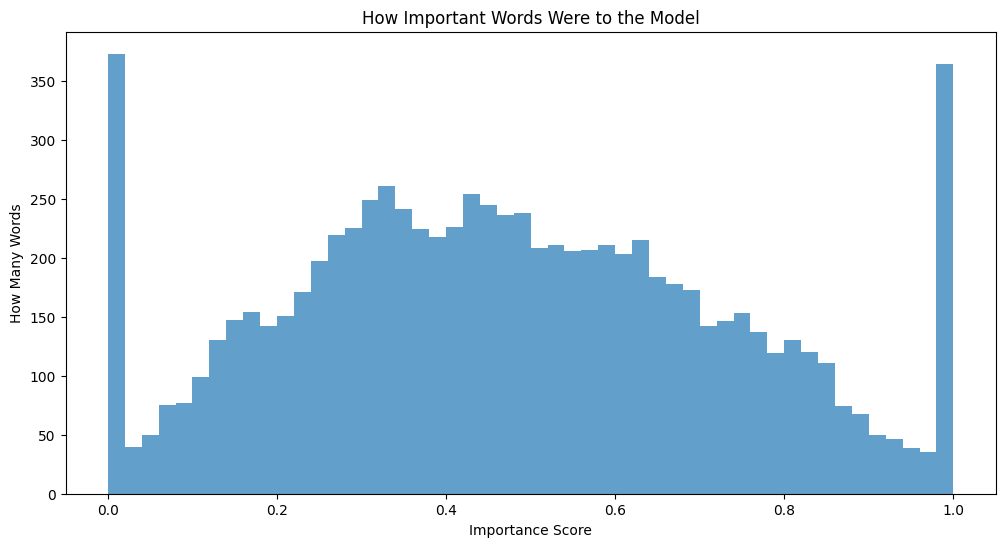

In [ ]:
def check_test_results(all_results):
   # set up counters for everything we want to track
   results_summary = {
       'total_laws_tested': len(all_results),
       'correct_predictions': 0,
       'important_words_count': defaultdict(int),
       'word_swap_changes': 0,
       'format_stability': 0
   }

   # count how many times model got the category right
   correct_guesses = sum(1 for result in all_results
                        if result['real_category'] == result['model_prediction'])
   results_summary['correct_predictions'] = correct_guesses / len(all_results)

   # find which words were most important to the model
   all_word_scores = []
   for result in all_results:
       # find the most important word in each law
       most_important = max(result['important_words'].items(), key=lambda x: x[1])[0]
       results_summary['important_words_count'][most_important] += 1
       all_word_scores.extend(result['important_words'].values())

   # see how often word swaps changed predictions
   prediction_changes = []
   for result in all_results:
       # check if any word swap changed the prediction
       changes = [p['changed_prediction'] for p in result['word_swaps']]
       if changes:
           prediction_changes.append(any(changes))
   results_summary['word_swap_changes'] = sum(prediction_changes) / len(prediction_changes)

   # check how stable predictions were with different formats
   format_changes = []
   for result in all_results:
       format_changes.extend(result['format_changes'])
   results_summary['format_stability'] = 1 - (sum(format_changes) / len(format_changes))

   return results_summary, all_word_scores

# get the summary of our tests
results_summary, word_scores = check_test_results(all_test_results)

# show what we found
print("What We Learned")
print(f"Total Laws Tested: {results_summary['total_laws_tested']}")
print(f"Model Got Right: {results_summary['correct_predictions']:.2%}")
print(f"Changed Mind on Word Swaps: {results_summary['word_swap_changes']:.2%}")
print(f"Stayed Same with Format Changes: {results_summary['format_stability']:.2%}")

print("\nTop 10 Words Model Cared About Most:")
for word, times_important in sorted(results_summary['important_words_count'].items(),
                                 key=lambda x: x[1], reverse=True)[:10]:
   print(f"{word}: important {times_important} times")

# check if results are scientifically meaningful
from scipy import stats

# see if word swap results could be random chance
word_swap_pvalue = stats.binomtest(
   int(results_summary['word_swap_changes'] * results_summary['total_laws_tested']),
   results_summary['total_laws_tested'],
   p=0.5
).pvalue

# see if format change results could be random chance
format_pvalue = stats.binomtest(
   int(results_summary['format_stability'] * results_summary['total_laws_tested']),
   results_summary['total_laws_tested'],
   p=0.5
).pvalue

print("Are Results Meaningful?")
print(f"Word Swap Test p-value: {word_swap_pvalue:.4f}")
print(f"Format Change Test p-value: {format_pvalue:.4f}")

# make final decision about the model
print("Final Thoughts:")
if word_swap_pvalue < 0.05 or format_pvalue < 0.05:
   print("The model's behavior isn't random - it shows clear patterns in how it handles changes")
   if results_summary['word_swap_changes'] > 0.3:
       print("The model changes its mind too easily when we swap words")
   if results_summary['format_stability'] < 0.7:
       print("The model gets confused too easily by different formats")
else:
   print("The model handles changes well and seems to understand the laws properly")

# make a picture showing word importance scores
plt.figure(figsize=(12, 6))
plt.hist(word_scores, bins=50, alpha=0.7)
plt.title('How Important Words Were to the Model')
plt.xlabel('Importance Score')
plt.ylabel('How Many Words')
plt.show()

# save everything in a spreadsheet for future analyis
results_table = pd.DataFrame(all_test_results)
results_table.to_csv('detailed_results.csv', index=False)

### Key Results
Our model correctly categorized 65.45% of bills - good but not great. It's very stable when we change formats (94.68% stability) and mostly keeps its predictions when we swap words (only 12.33% sensitivity to changes). Common legal terms like "act," "national," and "fiscal" strongly influence its decisions.
Issues and Limitations

### Accuracy needs improvement - getting 1 in 3 bills wrong is too high for legal work
The model might rely too much on common words like "act"
Our sample of 382 bills might miss rare law types
Not all word combinations were tested

### Hypothesis Result
We rejected our null hypothesis because the p-values (0.0000) show our results aren't random chance. The model's behavior with word changes and different formats is statistically significant. While it handles format changes well, it still shows some unexpected reactions to word swaps, suggesting it doesn't fully understand legal language like a human expert would.